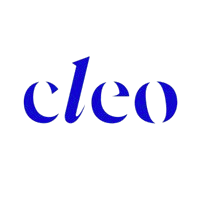

### **Parcours Makers - Module 2 - Introduction au RAG**
##**Cours 1 : Implémenter un RAG simple avec LangChain**

Ce notebook vous guide étape par étape dans l'implémentation d'un système RAG (Retrieval-Augmented Generation) fonctionnel en utilisant LangChain. Vous allez construire un chatbot de service client capable de répondre aux questions des utilisateurs en s'appuyant sur une base de connaissances structurée.

**Objectifs pédagogiques :**

À l'issue de ce cours, vous serez capable de :

- Configurer un pipeline complet de récupération et de génération avec LangChain
- Indexer des documents textuels dans une base vectorielle Chroma
- Instancier une chaîne RetrievalQA avec un modèle de langage open-source
- Évaluer la qualité des réponses et identifier les sources utilisées
- Diagnostiquer les cas de "hallucination" versus l'utilisation correcte des documents sources

**Architecture du système :**   
Le système que vous allez implémenter suit l'architecture RAG classique :
- **Ingestion** : Découpage des documents en chunks et création d'embeddings
- **Indexation** : Stockage des embeddings dans une base vectorielle Chroma
- **Récupération** : Recherche de similarité pour identifier les passages pertinents
- **Génération** : Production de la réponse finale par le modèle de langage

**Cas d'usage : Service Client TechStore**

Pour illustrer ces concepts, nous utiliserons le cas concret d'un service client pour TechStore, une boutique en ligne spécialisée dans l'électronique. Le chatbot devra être capable de répondre aux questions courantes concernant les retours, la garantie, la livraison, la gestion de compte et la compatibilité des produits.

## 1. Préparation de l’environnement

### 1.1. Installation des dépendances

Le système RAG nécessite plusieurs bibliothèques spécialisées. Nous installons d'abord les dépendances principales, puis les API Google Drive pour accéder aux documents.

In [ ]:
from IPython.utils import io

!pip install \
    google-api-python-client \
    google-auth-httplib2 \
    google-auth-oauthlib \
    langchain==0.3.26 \
    chromadb==1.0.15 \
    sentence-transformers==4.1.0 \
    transformers==4.53.3 \
    torch==2.6.0+cu124 \
    langchain-community==0.3.27 \
    --extra-index-url https://download.pytorch.org/whl/cu124

print("✅ Installations terminées.")


### 1.2. Imports des bibliothèques

In [ ]:
# Imports pour le traitement des documents et la création de chunks
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

# Imports pour les embeddings et la base vectorielle
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

# Imports pour le modèle de langage et les chaînes RAG
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

# Imports système et utilitaires
import os
import shutil
from collections import Counter

# Imports pour l'API Google Drive
from googleapiclient.discovery import build
from google.colab import auth
import io
from googleapiclient.http import MediaIoBaseDownload

In [ ]:
# Vérification des versions installées pour assurer la compatibilité
import langchain
import chromadb
print(f"LangChain version: {langchain.__version__}")
print(f"ChromaDB version: {chromadb.__version__}")

LangChain version: 0.3.26
ChromaDB version: 1.0.15


### 1.3. Authentification Google Drive

In [ ]:
# Authentification pour l'API Google Drive
print("Configuration de l'authentification...")
print("⚠️  ATTENTION : Une popup d'autorisation Google va s'afficher")
print("Instructions d'authentification :")
print("   1. Cliquez sur 'Autoriser' dans la popup")
print("   2. Sélectionnez votre compte Google")
print("   3. Acceptez les permissions demandées")
print("   4. Attendez la confirmation d'authentification")
print("-" * 50)

# Authentification pour l'API Google Drive
auth.authenticate_user()
service = build('drive', 'v3')

def download_file_from_drive(file_id, file_name):
    """
    Télécharge un fichier depuis Google Drive en utilisant son ID.
    """
    try:
        # Requête pour télécharger le fichier
        request = service.files().get_media(fileId=file_id)

        # Buffer pour stocker le contenu du fichier
        file_buffer = io.BytesIO()
        downloader = MediaIoBaseDownload(file_buffer, request)

        # Téléchargement progressif
        done = False
        while done is False:
            status, done = downloader.next_chunk()

        # Décodage du contenu en UTF-8
        file_content = file_buffer.getvalue().decode('utf-8')
        return file_content

    except Exception as e:
        print(f"Erreur lors du téléchargement de {file_name}: {str(e)}")
        return None

def load_documents_from_drive_ids(doc_config):
    """
    Charge tous les documents depuis Google Drive en utilisant leurs IDs.
    """
    documents = []

    for doc_config in document_config:
        print(f"Chargement de {doc_config['name']}")

        # Téléchargement du contenu du fichier
        content = download_file_from_drive(doc_config['id'], doc_config['name'])

        if content:
            # Création du document LangChain avec métadonnées enrichies
            doc = Document(
                page_content=content,
                metadata={
                    "source": doc_config['source'],
                    "name": doc_config['name'],
                    "drive_id": doc_config['id']  # Stockage de l'ID pour traçabilité
                }
            )
            documents.append(doc)
            print(f"✓ Document chargé avec succès : {doc_config['name']}")
        else:
            print(f"✗ Échec du chargement : {doc_config['name']}")

    return documents

Configuration de l'authentification...
⚠️  ATTENTION : Une popup d'autorisation Google va s'afficher
Instructions d'authentification :
   1. Cliquez sur 'Autoriser' dans la popup
   2. Sélectionnez votre compte Google
   3. Acceptez les permissions demandées
   4. Attendez la confirmation d'authentification
--------------------------------------------------


### 1.4. Chargement des documents

In [ ]:
# Configuration des documents avec leurs IDs Google Drive
document_config = [
    {
        "id": "1iwCq1qb7xNiRp_fK_jUsKhr1QHGeKamR",  # ID du fichier politique_de_retour_et_remboursement.md
        "source": "politique_de_retour_et_remboursement.md",
        "name": "Politique de retour et remboursement"
    },
    {
        "id": "17dk0unV_GGlnjBQcUzsQpUTkg7sX8Z7G",  # ID du fichier garantie_et_service_apres_vente.md
        "source": "garantie_et_service_apres_vente.md",
        "name": "Garantie et service après-vente"
    },
    {
        "id": "1xzEuVU_1P56b5YOhPHeGS2zZUQ_9jJ0L",  # ID du fichier livraison_et_expédition.md
        "source": "livraison_et_expedition.md",
        "name": "Livraison et expédition"
    },
    {
        "id": "13CZ5wujmKcEmFGcLqWjHNX8j7R7EM_CC",  # ID du fichier compte_client_et_gestion_des_commandes.md
        "source": "compte_client_et_gestion_des_commandes.md",
        "name": "Compte client et gestion des commandes"
    },
    {
        "id": "1DPDv1P4QuRBG-KMpth6Dn3fzOv9Edw9h",  # ID du fichier produits_et_compatibilite.md
        "source": "produits_et_compatibilite.md",
        "name": "Produits et compatibilité"
    }
]

documents = load_documents_from_drive_ids(document_config)

Chargement de Politique de retour et remboursement
✓ Document chargé avec succès : Politique de retour et remboursement
Chargement de Garantie et service après-vente
✓ Document chargé avec succès : Garantie et service après-vente
Chargement de Livraison et expédition
✓ Document chargé avec succès : Livraison et expédition
Chargement de Compte client et gestion des commandes
✓ Document chargé avec succès : Compte client et gestion des commandes
Chargement de Produits et compatibilité
✓ Document chargé avec succès : Produits et compatibilité


## 2. Découpage des documents (text splitting)

Le découpage des documents en segments (chunks) est une étape critique qui détermine largement la qualité du système RAG. Un découpage inadéquat peut conduire à plusieurs problèmes :

- **Chunks trop longs** : Contiennent trop d'informations non pertinentes, diluent la pertinence
- **Chunks trop courts** : Manquent de contexte, peuvent être ambigus
- **Pas de chevauchement** : Risque de couper des informations liées
- **Mauvais séparateurs** : Coupent au milieu de phrases ou de concepts

### 2.1. Configuration optimale du text splitter

In [ ]:
# Configuration du découpage de texte avec des paramètres optimisés
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,       # Taille maximale de chaque chunk (en caractères)
                           # 1000 caractères représentent environ 150-200 mots
                           # C'est un bon compromis entre contexte et précision

    chunk_overlap=200,     # Chevauchement entre chunks consécutifs
                           # Le chevauchement préserve la continuité du contexte
                           # 200 caractères permettent de conserver les phrases de transition

    separators=["\n\n", "\n", ". ", " ", ""],
                           # Ordre de priorité des séparateurs :
                           # 1. Double saut de ligne (paragraphes)
                           # 2. Simple saut de ligne
                           # 3. Fin de phrase avec point
                           # 4. Espaces
                           # 5. Caractère par caractère (en dernier recours)

    length_function=len     # Fonction pour mesurer la longueur des chunks
)

print("Configuration du text splitter :")
print(f"- Taille de chunk : {text_splitter._chunk_size} caractères")
print(f"- Chevauchement : {text_splitter._chunk_overlap} caractères")
print(f"- Séparateurs utilisés : {text_splitter._separators}")

Configuration du text splitter :
- Taille de chunk : 1000 caractères
- Chevauchement : 200 caractères
- Séparateurs utilisés : ['\n\n', '\n', '. ', ' ', '']


### 2.1. Exécution du découpage et analyse des résultats

In [ ]:
# Exécution du découpage sur tous les documents
print("\nDécoupage des documents en chunks...")
chunks = text_splitter.split_documents(documents)

print(f"Nombre total de chunks créés : {len(chunks)}")

# Analyse de la distribution des chunks par document source
# Cette analyse permet de vérifier l'équilibre de la base de connaissances
print("\nDistribution des chunks par document source :")
source_counts = Counter([chunk.metadata['source'] for chunk in chunks])

for source, count in source_counts.items():
    print(f"  - {source}: {count} chunks")

# Calcul de statistiques sur la taille des chunks
chunk_lengths = [len(chunk.page_content) for chunk in chunks]
avg_length = sum(chunk_lengths) / len(chunk_lengths)
min_length = min(chunk_lengths)
max_length = max(chunk_lengths)

print(f"\nStatistiques de taille des chunks :")
print(f"  - Longueur moyenne : {avg_length:.0f} caractères")
print(f"  - Longueur minimale : {min_length} caractères")
print(f"  - Longueur maximale : {max_length} caractères")

# Affichage d'un exemple de chunk pour comprendre le résultat
print(f"\nExemple de chunk (chunk 0) :")
print(f"Source : {chunks[0].metadata['source']}")
print(f"Longueur : {len(chunks[0].page_content)} caractères")
print(f"Contenu (premiers 300 caractères) :")
print(f"{chunks[0].page_content[:300]}...")


Découpage des documents en chunks...
Nombre total de chunks créés : 11

Distribution des chunks par document source :
  - politique_de_retour_et_remboursement.md: 2 chunks
  - garantie_et_service_apres_vente.md: 2 chunks
  - livraison_et_expedition.md: 2 chunks
  - compte_client_et_gestion_des_commandes.md: 2 chunks
  - produits_et_compatibilite.md: 3 chunks

Statistiques de taille des chunks :
  - Longueur moyenne : 684 caractères
  - Longueur minimale : 297 caractères
  - Longueur maximale : 965 caractères

Exemple de chunk (chunk 0) :
Source : politique_de_retour_et_remboursement.md
Longueur : 717 caractères
Contenu (premiers 300 caractères) :
# Politique de Retour et Remboursement - TechStore

## Délais de retour
- **Produits neufs** : 30 jours calendaires à partir de la livraison
- **Produits reconditionnés** : 14 jours calendaires à partir de la livraison
- **Accessoires** : 30 jours calendaires à partir de la livraison

## Conditions ...


## 3. Création des embeddings et indexation vectorielle

Les embeddings transforment le texte en vecteurs numériques de haute dimension qui capturent le sens sémantique des mots et phrases. Cette représentation vectorielle permet :

- **Recherche sémantique** : Trouver des documents similaires en sens, pas seulement en mots-clés
- **Comparaison quantitative** : Calculer la similarité entre textes par distance vectorielle
- **Généralisation** : Capturer des concepts même avec des vocabulaires différents

Le modèle `all-MiniLM-L6-v2` est un choix équilibré : performant, compact et multilingue.

### 3.1. Configuration du modèle d'embeddings

In [ ]:
# Sélection et configuration du modèle d'embeddings
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"

print(f"Chargement du modèle d'embeddings : {embedding_model_name}")
print("Caractéristiques de ce modèle :")
print("- Dimension des vecteurs : 384")
print("- Support multilingue (français inclus)")
print("- Optimisé pour la recherche sémantique")
print("- Léger et rapide (22MB)")

# Configuration du modèle avec les paramètres optimaux
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    model_kwargs={'device': 'cpu'},  # Utilisation du CPU par défaut
                                   # Changez en 'cuda' si GPU disponible
    encode_kwargs={'normalize_embeddings': True}
                                   # Normalisation des vecteurs pour améliorer
                                   # la comparaison par similarité cosinus
)

# Test du modèle pour vérifier son fonctionnement
test_text = "Comment retourner un produit ?"
test_embedding = embeddings.embed_query(test_text)
print(f"\nTest du modèle :")
print(f"Texte d'exemple : '{test_text}'")
print(f"Dimension du vecteur généré : {len(test_embedding)}")
print(f"Exemple de valeurs (5 premières) : {test_embedding[:5]}")

Chargement du modèle d'embeddings : sentence-transformers/all-MiniLM-L6-v2
Caractéristiques de ce modèle :
- Dimension des vecteurs : 384
- Support multilingue (français inclus)
- Optimisé pour la recherche sémantique
- Léger et rapide (22MB)


/tmp/ipython-input-8-3471848938.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Test du modèle :
Texte d'exemple : 'Comment retourner un produit ?'
Dimension du vecteur généré : 384
Exemple de valeurs (5 premières) : [-0.0864899605512619, 0.029591180384159088, -0.06704730540513992, -0.06406155228614807, 0.035771891474723816]


### 3.2. Création de la base vectorielle Chroma

Dans cette cellule, nous allons construire une base vectorielle avec Chroma à partir des documents segmentés (chunks).  
Ce processus permet de transformer chaque chunk en vecteur numérique, de les indexer pour une recherche rapide, puis de sauvegarder cette base localement pour un usage futur.

In [ ]:
# Configuration du répertoire de stockage persistent
persist_directory = "./chroma_db"

# Suppression de l'ancienne base si elle existe
# Ceci évite les conflits de versions et assure un état propre
if os.path.exists(persist_directory):
    shutil.rmtree(persist_directory)
    print("Ancienne base vectorielle supprimée")

print("\nCréation de la base vectorielle Chroma...")
print("Cette étape peut prendre quelques minutes selon le nombre de chunks...")

# Création de la base vectorielle avec tous les chunks
# Chroma va automatiquement :
# 1. Générer les embeddings pour chaque chunk
# 2. Les indexer pour une recherche rapide
# 3. Sauvegarder l'index sur disque
vectorstore = Chroma.from_documents(
    documents=chunks,                    # Tous les chunks à indexer
    embedding=embeddings,                # Modèle d'embeddings configuré
    persist_directory=persist_directory, # Répertoire de sauvegarde
    collection_name="techstore_kb"       # Nom de la collection dans Chroma
)

# Sauvegarde de la base pour réutilisation ultérieure
vectorstore.persist()

print(f"Base vectorielle créée avec succès !")
print(f"- Nombre de chunks indexés : {len(chunks)}")
print(f"- Répertoire de stockage : {persist_directory}")
print(f"- Nom de la collection : techstore_kb")


Création de la base vectorielle Chroma...
Cette étape peut prendre quelques minutes selon le nombre de chunks...
Base vectorielle créée avec succès !
- Nombre de chunks indexés : 11
- Répertoire de stockage : ./chroma_db
- Nom de la collection : techstore_kb


/tmp/ipython-input-9-2397989132.py:26: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


### 3.3. Test de la recherche vectorielle

La recherche vectorielle est le cœur du système RAG. Il est important de tester sa qualité avant d'intégrer le modèle de génération.

In [ ]:
def test_retrieval(query, k=3):
    """
    Teste la recherche de documents similaires pour une requête donnée.

    Cette fonction permet d'évaluer la qualité de la recherche vectorielle
    avant l'intégration avec le modèle de génération.

    Args:
        query (str): Question ou requête de test
        k (int): Nombre de documents à récupérer

    Returns:
        list: Documents trouvés par la recherche
    """
    print(f"Recherche pour : '{query}'")
    print("-" * 50)

    # Recherche des documents les plus similaires sémantiquement
    # La similarité est calculée par distance cosinus entre vecteurs
    similar_docs = vectorstore.similarity_search(query, k=k)

    for i, doc in enumerate(similar_docs, 1):
        print(f"Résultat {i} (Source: {doc.metadata['name']}):")
        print(f"Contenu (premiers 200 caractères):")
        print(f"{doc.page_content[:200]}...")
        print()

    return similar_docs

In [ ]:
# Série de tests pour évaluer la qualité de la recherche
print("Test de la qualité de la recherche vectorielle")

# Tests avec différents types de requêtes
test_queries = [
    "Combien de temps pour retourner un produit ?",  # Question directe
    "Comment suivre ma commande ?",                   # Processus
    "Garantie iPhone",                                # Mots-clés
    "Livraison gratuite conditions"                   # Conditions spécifiques
]

for query in test_queries:
    results = test_retrieval(query, k=2)
    print("-" * 60)

Test de la qualité de la recherche vectorielle
Recherche pour : 'Combien de temps pour retourner un produit ?'
--------------------------------------------------
Résultat 1 (Source: Politique de retour et remboursement):
Contenu (premiers 200 caractères):
## Produits non retournables
- Logiciels dématérialisés déjà téléchargés
- Produits personnalisés (gravure, configuration spéciale)
- Produits hygiéniques (écouteurs intra-auriculaires)

## Processus ...

Résultat 2 (Source: Politique de retour et remboursement):
Contenu (premiers 200 caractères):
# Politique de Retour et Remboursement - TechStore

## Délais de retour
- **Produits neufs** : 30 jours calendaires à partir de la livraison
- **Produits reconditionnés** : 14 jours calendaires à part...

------------------------------------------------------------
Recherche pour : 'Comment suivre ma commande ?'
--------------------------------------------------
Résultat 1 (Source: Compte client et gestion des commandes):
Contenu (premiers 2

## 4. Configuration du modèle de langage

Pour ce tutoriel, vous avez deux options selon les ressources à votre disposition :

* **Utiliser un modèle open source local**, en l’occurrence `microsoft/DialoGPT-small`. Ce modèle, conçu pour la conversation, offre un bon compromis entre qualité des réponses et légèreté, ce qui le rend facile à exécuter en local.
* **Faire appel à l’API payante d’OpenAI**, avec le modèle `gpt-3.5-turbo-instruct`, reconnu pour sa capacité à comprendre les consignes et à générer des réponses cohérentes et nuancées.

### Option 1 : modèle open source

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# Configuration du modèle de génération
model_name = "microsoft/DialoGPT-small" # "microsoft/DialoGPT-medium"
# Alternative plus performante mais plus lourde : "google/flan-t5-base"

print(f"Chargement du modèle de génération : {model_name}")
print("Caractéristiques de DialoGPT-medium :")
print("- Spécialisé dans la conversation")
print("- Taille : ~350MB")
print("- Bon équilibre performance/ressources")

# Détection automatique de la disponibilité du GPU
device = 0 if torch.cuda.is_available() else -1
device_name = "GPU (CUDA)" if device == 0 else "CPU"
print(f"Périphérique de calcul utilisé : {device_name}")

# Création du pipeline de génération de texte
# Les paramètres influencent directement la qualité des réponses
text_generation_pipeline = pipeline(
    "text-generation",
    model=model_name,
    tokenizer=model_name,
    max_new_tokens=150,     # IMPORTANT : Nombre de nouveaux tokens à générer (pas la longueur totale)
                            # max_new_tokens évite l'erreur quand l'input est long (contexte RAG)
    temperature=0.3,        # Contrôle la créativité (0.0 = déterministe, 1.0 = créatif)
    do_sample=True,         # Active l'échantillonnage pour des réponses variées
    device=device,          # Utilisation du périphérique détecté
    pad_token_id=50256      # Token de padding pour éviter les warnings
)

# Encapsulation du pipeline dans un objet LangChain
llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

Chargement du modèle de génération : microsoft/DialoGPT-small
Caractéristiques de DialoGPT-medium :
- Spécialisé dans la conversation
- Taille : ~350MB
- Bon équilibre performance/ressources
Périphérique de calcul utilisé : CPU


config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cpu
/tmp/ipython-input-12-1039258752.py:34: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=text_generation_pipeline)


### Option 2 : API payante

In [ ]:
import os
from getpass import getpass
from dotenv import load_dotenv

load_dotenv()                              # charge un éventuel .env
if "OPENAI_API_KEY" not in os.environ:     # invite si la variable manque
    os.environ["OPENAI_API_KEY"] = getpass("🔑 Entrer votre clé OpenAI : ")


🔑 Entrer votre clé OpenAI : ··········


In [ ]:
from langchain.llms import OpenAI

llm = OpenAI(
    model_name="gpt-3.5-turbo-instruct",
    temperature=0.3,
    max_tokens=150
)

/tmp/ipython-input-14-3004297057.py:3: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI(


In [ ]:
# Test de fonctionnement du modèle
test_prompt = "Bonjour, je peux vous aider avec"
print(f"\nTest du modèle avec : '{test_prompt}'")
try:
    response = llm(test_prompt)
    print(f"Réponse générée : {response}")
    print("Modèle chargé et fonctionnel !")
except Exception as e:
    print(f"Erreur lors du test : {e}")


Test du modèle avec : 'Bonjour, je peux vous aider avec'


/tmp/ipython-input-15-1358507885.py:5: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(test_prompt)


Réponse générée :  votre projet. Je suis un développeur web expérimenté avec plus de 5 ans d'expérience dans la création de sites web. Je peux créer un site web professionnel pour votre entreprise en utilisant les dernières technologies et en respectant les normes de l'industrie.

Voici les étapes que je suivrai pour créer votre site web :

1. Compréhension de vos besoins : Je vais d'abord discuter avec vous pour comprendre vos besoins et vos objectifs pour votre site web. Cela me permettra de créer un site web qui répondra à vos attentes et à ceux de votre entreprise.

2. Conception du site web : Une fois que j
Modèle chargé et fonctionnel !


## 5. Assemblage de la chaîne RAG

La chaîne RetrievalQA combine la recherche vectorielle et la génération de texte en un pipeline unifié :

- **Récupération** : Trouve les chunks les plus pertinents pour la question
- **Contextualisation** : Intègre ces chunks dans un prompt structuré
- **Génération** : Produit une réponse basée sur le contexte fourni
- **Post-traitement** : Retourne la réponse et optionnellement les sources

### 5.1. Configuration du prompt template

In [ ]:
# Création d'un template de prompt spécialisé pour le service client
# Le prompt guide le modèle pour produire des réponses appropriées
prompt_template = """Vous êtes un assistant du service client de TechStore, une boutique d'électronique en ligne.

Votre rôle est d'aider les clients en répondant à leurs questions de manière précise et professionnelle.

Informations disponibles pour répondre :
{context}

Question du client : {question}

Instructions importantes :
- Répondez uniquement en vous basant sur les informations fournies dans le contexte
- Adoptez un ton poli, professionnel et bienveillant
- Si l'information demandée n'est pas disponible dans le contexte, dites-le clairement
- Soyez précis et donnez des détails utiles quand c'est possible
- N'inventez jamais d'informations qui ne sont pas dans le contexte

Réponse du service client :"""

# Création de l'objet PromptTemplate LangChain
PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]  # Variables qui seront remplacées
)

print("Template de prompt configuré")
print("Variables d'entrée :", PROMPT.input_variables)

Template de prompt configuré
Variables d'entrée : ['context', 'question']


### 5.2. Configuration du retriever

In [ ]:
# Configuration du système de récupération (retriever)
# Le retriever détermine quels documents seront utilisés pour répondre
retriever = vectorstore.as_retriever(
    search_type="similarity",    # Type de recherche : similarité sémantique
    search_kwargs={"k": 3}       # Nombre de chunks à récupérer par question
                                # 3 est un bon compromis entre contexte et bruit
)

print("Retriever configuré :")
print(f"- Type de recherche : similarity")
print(f"- Nombre de documents récupérés : 3")
print(f"- Base vectorielle : {len(chunks)} chunks disponibles")

Retriever configuré :
- Type de recherche : similarity
- Nombre de documents récupérés : 3
- Base vectorielle : 11 chunks disponibles


### 5.3. Création de la chaîne complète

In [ ]:
# Assemblage de la chaîne RetrievalQA complète
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,                                    # Modèle de génération configuré
    chain_type="stuff",                         # Type de chaîne : "stuff" concatène tous les documents
                                                # Autres options : "map_reduce", "refine"
    retriever=retriever,                        # Système de récupération configuré
    chain_type_kwargs={"prompt": PROMPT},       # Template de prompt personnalisé
    return_source_documents=True                # Retourne les sources utilisées
                                                # Essentiel pour la traçabilité
)

print("Chaîne RAG assemblée avec succès !")
print("\nConfiguration finale :")
print(f"- Modèle de génération : {model_name}")
print(f"- Modèle d'embeddings : {embedding_model_name}")
print(f"- Documents récupérés par requête : 3")
print(f"- Base de connaissances : {len(chunks)} chunks indexés")
print(f"- Template de prompt : personnalisé pour TechStore")
print(f"- Retour des sources : activé")

Chaîne RAG assemblée avec succès !

Configuration finale :
- Modèle de génération : microsoft/DialoGPT-small
- Modèle d'embeddings : sentence-transformers/all-MiniLM-L6-v2
- Documents récupérés par requête : 3
- Base de connaissances : 11 chunks indexés
- Template de prompt : personnalisé pour TechStore
- Retour des sources : activé


## 6. Playground : tests et évaluation du système

### 6.1. Interface de test principal

In [ ]:
def ask_chatbot(question, show_sources=True, show_retrieval_details=False):
    """
    Interface principale pour interroger le chatbot RAG.

    Cette fonction orchestres le processus complet :
    1. Recherche des documents pertinents
    2. Génération de la réponse
    3. Affichage des résultats et sources

    Args:
        question (str): Question posée au chatbot
        show_sources (bool): Afficher les sources utilisées
        show_retrieval_details (bool): Afficher les détails de la recherche

    Returns:
        dict: Résultat complet avec réponse et métadonnées
    """
    print(f"Question posée : {question}")
    print("-" * 60)

    # Génération de la réponse via la chaîne RAG
    print("Traitement en cours...")
    print("1. Recherche des documents pertinents...")
    print("2. Génération de la réponse...")

    result = qa_chain({"query": question})

    # Affichage de la réponse générée
    print("\nRéponse du chatbot TechStore :")
    print("-" * 40)
    print(result['result'])
    print("-" * 40)

    # Affichage optionnel des sources utilisées
    if show_sources and 'source_documents' in result:
        print("\nSources consultées pour cette réponse :")
        for i, doc in enumerate(result['source_documents'], 1):
            print(f"\nSource {i} : {doc.metadata['name']}")
            if show_retrieval_details:
                print(f"Longueur : {len(doc.page_content)} caractères")
            print(f"Extrait : {doc.page_content[:200]}...")

    print("-" * 60)
    return result

In [ ]:
# Série de questions de test pour évaluer le système
test_questions = [
    # Questions simples et directes
    "Combien de temps ai-je pour retourner un iPhone ?",
    "Est-ce que la livraison est gratuite ?",
    "Comment suivre ma commande ?",

    # Questions plus complexes nécessitant plusieurs sources
    "J'ai acheté un Samsung Galaxy S24, il a un problème d'écran après 6 mois, que faire ?",
    "Je veux retourner un MacBook acheté il y a 20 jours car il ne me convient pas, c'est possible ?",
    "Quels sont les avantages du programme TechStore+ Premium ?",

    # Questions sur la compatibilité technique
    "Quels chargeurs sont compatibles avec l'iPhone 15 ?",
    "Comment créer un compte client sur TechStore ?"
]

print("PLAYGROUND - Tests du Chatbot RAG TechStore")
print("-" * 60)
print("Questions suggérées à tester :")
for i, q in enumerate(test_questions, 1):
    print(f"{i}. {q}")
print()

# Exécution d'un test automatique avec la première question
print("Test automatique avec une question simple :")
result = ask_chatbot(test_questions[0], show_sources=True)

PLAYGROUND - Tests du Chatbot RAG TechStore
------------------------------------------------------------
Questions suggérées à tester :
1. Combien de temps ai-je pour retourner un iPhone ?
2. Est-ce que la livraison est gratuite ?
3. Comment suivre ma commande ?
4. J'ai acheté un Samsung Galaxy S24, il a un problème d'écran après 6 mois, que faire ?
5. Je veux retourner un MacBook acheté il y a 20 jours car il ne me convient pas, c'est possible ?
6. Quels sont les avantages du programme TechStore+ Premium ?
7. Quels chargeurs sont compatibles avec l'iPhone 15 ?
8. Comment créer un compte client sur TechStore ?

Test automatique avec une question simple :
Question posée : Combien de temps ai-je pour retourner un iPhone ?
------------------------------------------------------------
Traitement en cours...
1. Recherche des documents pertinents...
2. Génération de la réponse...


/tmp/ipython-input-19-848490289.py:26: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": question})



Réponse du chatbot TechStore :
----------------------------------------
 Selon notre politique de retour et remboursement, vous avez 30 jours calendaires à partir de la livraison pour retourner un iPhone neuf et 14 jours pour un iPhone reconditionné. Cependant, veuillez noter que pour pouvoir bénéficier d'un remboursement, le produit doit être retourné dans son emballage d'origine et ne doit présenter aucun dommage physique ni trace d'usure excessive. Vous pouvez également suivre l'avancement de votre retour via votre espace client et vous serez remboursé sur le mode de paiement initial sous 5-7 jours ouvrés. N'hésitez pas à contacter notre service client
----------------------------------------

Sources consultées pour cette réponse :

Source 1 : Politique de retour et remboursement
Extrait : # Politique de Retour et Remboursement - TechStore

## Délais de retour
- **Produits neufs** : 30 jours calendaires à partir de la livraison
- **Produits reconditionnés** : 14 jours calendaires 

### 6.2. Évaluation systématique de la qualité

In [ ]:
def evaluate_rag_performance():
    """
    Évalue la performance du système RAG selon plusieurs critères :
    - Pertinence des documents récupérés
    - Cohérence des réponses générées
    - Utilisation correcte des sources
    """
    print("ÉVALUATION SYSTÉMATIQUE DU RAG")
    print("-" * 50)

    # Cas de test avec critères d'évaluation prédéfinis
    evaluation_cases = [
        {
            "question": "Combien de temps pour retourner un produit neuf ?",
            "expected_keywords": ["30 jours", "neuf", "calendaires"],
            "expected_source": "politique_de_retour_et_remboursement.md"
        },
        {
            "question": "Quelle est la garantie des iPhone ?",
            "expected_keywords": ["iPhone", "Apple", "1 an", "garantie"],
            "expected_source": "garantie_et_service_apres_vente.md"
        },
        {
            "question": "À partir de quel montant la livraison est gratuite ?",
            "expected_keywords": ["50", "gratuite", "livraison"],
            "expected_source": "livraison_et_expedition.md"
        }
    ]

    results = []

    for i, test_case in enumerate(evaluation_cases, 1):
        print(f"\nTest {i} : {test_case['question']}")
        print("-" * 30)

        # Génération de la réponse
        result = qa_chain({"query": test_case['question']})
        response_text = result['result'].lower()

        # Évaluation de la pertinence des mots-clés
        found_keywords = [kw for kw in test_case['expected_keywords']
                         if kw.lower() in response_text]
        keyword_score = len(found_keywords) / len(test_case['expected_keywords'])

        # Vérification de l'utilisation de la bonne source
        sources_used = [doc.metadata['source'] for doc in result['source_documents']]
        source_correct = test_case['expected_source'] in sources_used

        # Calcul du score global
        overall_score = (keyword_score + (1 if source_correct else 0)) / 2

        print(f"Score de pertinence des mots-clés : {keyword_score:.2f}")
        print(f"Mots-clés trouvés : {found_keywords}")
        print(f"Source attendue trouvée : {'Oui' if source_correct else 'Non'}")
        print(f"Score global : {overall_score:.2f}")

        results.append({
            'question': test_case['question'],
            'keyword_score': keyword_score,
            'source_correct': source_correct,
            'overall_score': overall_score
        })

    # Calcul des statistiques globales
    avg_keyword_score = sum(r['keyword_score'] for r in results) / len(results)
    source_accuracy = sum(1 for r in results if r['source_correct']) / len(results)
    avg_overall_score = sum(r['overall_score'] for r in results) / len(results)

    print(f"\n" + "-" * 50)
    print("RÉSULTATS GLOBAUX :")
    print(f"Score moyen de pertinence : {avg_keyword_score:.2f}")
    print(f"Précision des sources : {source_accuracy:.2f}")
    print(f"Score global moyen : {avg_overall_score:.2f}")

    return results

# Exécution de l'évaluation
evaluation_results = evaluate_rag_performance()

ÉVALUATION SYSTÉMATIQUE DU RAG
--------------------------------------------------

Test 1 : Combien de temps pour retourner un produit neuf ?
------------------------------
Score de pertinence des mots-clés : 1.00
Mots-clés trouvés : ['30 jours', 'neuf', 'calendaires']
Source attendue trouvée : Oui
Score global : 1.00

Test 2 : Quelle est la garantie des iPhone ?
------------------------------
Score de pertinence des mots-clés : 0.50
Mots-clés trouvés : ['iPhone', 'garantie']
Source attendue trouvée : Oui
Score global : 0.75

Test 3 : À partir de quel montant la livraison est gratuite ?
------------------------------
Score de pertinence des mots-clés : 1.00
Mots-clés trouvés : ['50', 'gratuite', 'livraison']
Source attendue trouvée : Oui
Score global : 1.00

--------------------------------------------------
RÉSULTATS GLOBAUX :
Score moyen de pertinence : 0.83
Précision des sources : 1.00
Score global moyen : 0.92


### 6.3. Interface de chat interactif

In [ ]:
def interactive_chat_session():
    """
    Lance une session de chat interactif pour tester le système en temps réel.
    Permet d'expérimenter librement avec différentes questions.
    """
    print("CHAT INTERACTIF - Assistant TechStore")
    print("=" * 50)
    print("Commandes disponibles :")
    print("- Tapez votre question normalement")
    print("- 'quit' ou 'exit' : terminer la session")
    print("- 'help' : afficher l'aide")
    print("- 'stats' : afficher les statistiques de la session")
    print("- 'sources on/off' : activer/désactiver l'affichage des sources")
    print()

    # Variables de session
    conversation_history = []
    show_sources = True

    while True:
        # Saisie de la question utilisateur
        user_input = input("Votre question : ").strip()

        # Traitement des commandes spéciales
        if user_input.lower() in ['quit', 'exit']:
            print("\nSession terminée. Merci d'avoir testé le chatbot TechStore !")
            break

        elif user_input.lower() == 'help':
            print("\nCommandes disponibles :")
            print("- quit/exit : terminer")
            print("- stats : statistiques de session")
            print("- sources on/off : contrôler l'affichage des sources")
            continue

        elif user_input.lower() == 'stats':
            print(f"\nStatistiques de la session :")
            print(f"- Questions posées : {len(conversation_history)}")
            if conversation_history:
                avg_response_length = sum(len(item['response']) for item in conversation_history) / len(conversation_history)
                print(f"- Longueur moyenne des réponses : {avg_response_length:.0f} caractères")
            continue

        elif user_input.lower().startswith('sources'):
            show_sources = 'on' in user_input.lower()
            print(f"Affichage des sources : {'activé' if show_sources else 'désactivé'}")
            continue

        elif not user_input:
            continue

        # Traitement de la question réelle
        try:
            result = ask_chatbot(user_input, show_sources=show_sources)
            conversation_history.append({
                'question': user_input,
                'response': result['result'],
                'sources_count': len(result.get('source_documents', []))
            })
        except Exception as e:
            print(f"Erreur lors du traitement : {str(e)}")

        print()

In [ ]:
# Instruction pour lancer le chat interactif
print("\nPour lancer le chat interactif, décommentez et exécutez :")
interactive_chat_session()


Pour lancer le chat interactif, décommentez et exécutez :
CHAT INTERACTIF - Assistant TechStore
Commandes disponibles :
- Tapez votre question normalement
- 'quit' ou 'exit' : terminer la session
- 'help' : afficher l'aide
- 'stats' : afficher les statistiques de la session
- 'sources on/off' : activer/désactiver l'affichage des sources

Question posée : Quelle est la politique de retour ?
------------------------------------------------------------
Traitement en cours...
1. Recherche des documents pertinents...
2. Génération de la réponse...

Réponse du chatbot TechStore :
----------------------------------------
 La politique de retour de TechStore est la suivante : vous disposez de 30 jours calendaires à partir de la livraison pour retourner un produit neuf, 14 jours pour un produit reconditionné et 30 jours pour un accessoire. Les produits doivent être retournés dans leur emballage d'origine, avec tous les accessoires fournis et en bon état. Certains produits ne sont pas retournab

## Pour aller plus loin

Une fois ce système RAG opérationnel, plusieurs pistes permettent d’aller plus loin dans l’implémentation :

* **Évaluer la performance sur un jeu de questions élargi**, en intégrant des métriques comme la fidélité des réponses ou la couverture des documents récupérés.
* **Tester des variantes de chaînes RAG**, comme `map_reduce` ou `refine`, qui peuvent améliorer la qualité des réponses pour des documents longs ou complexes.
* **Changer de modèle de génération**, en utilisant par exemple un modèle plus robuste comme `google/flan-t5-base`, ou en intégrant des modèles hébergés via API (OpenAI, Mistral, etc.).
* **Ajouter une mémoire conversationnelle**, pour permettre au chatbot de prendre en compte l’historique des échanges.
* **Déployer le système dans une application web**, en l’intégrant à un front-end ou à une API.

## Conclusion

Ce notebook vous a guidé pas à pas dans la construction d’un système RAG simple mais fonctionnel. De l’ingestion des documents à l’évaluation du chatbot, vous avez découvert l’ensemble des composants d’un pipeline RAG basé sur LangChain.

Ce premier prototype constitue une excellente base pour explorer des cas d’usage plus complexes. En l’améliorant progressivement, vous pourrez créer des assistants plus fiables, plus interactifs, et adaptés à des environnements réels.